## TESTING


c:\Users\Anand\Desktop\projects\Davies_WeatherHack\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,153 (121.69 KB)

 Trainable params: 31,153 (121.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0055 - val_loss: 3.2101e-04
Epoch 2/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0014 - val_loss: 2.4167e-04
Epoch 3/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 9.7208e-04 - val_loss: 1.8330e-04
Epoch 4/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 7.8961e-04 - val_loss: 1.6751e-04
Epoch 5/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 7.6069e-04 - val_loss: 1.3358e-04
Epoch 6/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 6.2827e-04 - val_loss: 1.2161e-04
Epoch 7/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 4.9069e-04 - val_loss: 1.2428e-04
Epoch 8/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 4.9121e-04 - val_loss: 1.4042e-04
Epoch 9/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 4.6051e-04 - val_loss: 1.4739e-04
Epoch 10/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 4.6352e-04 - val_loss: 1.1151e-04
Epoch 11/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - 

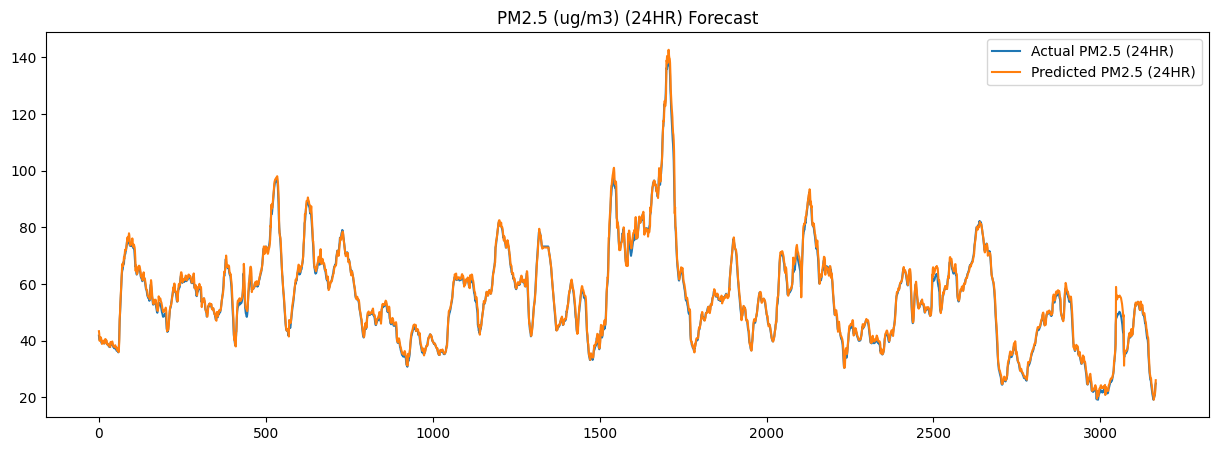

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the dataset
file_path = './AQI_Weather_Data.csv'
df = pd.read_csv(file_path)

df.set_index('Date_Start Time', inplace=True)
df.drop(['Sr.NO', 'End Time'], axis=1, inplace=True)

# Ensure PM2.5 columns are float
df['PM2.5 (ug/m3) (24HR)'] = df['PM2.5 (ug/m3) (24HR)'].astype(float)
df['PM2.5 (ug/m3) (MIN)'] = df['PM2.5 (ug/m3) (MIN)'].astype(float)
df['PM2.5 (ug/m3) (MAX)'] = df['PM2.5 (ug/m3) (MAX)'].astype(float)

# Select the features for forecasting
features = ['PM2.5 (ug/m3) (24HR)', 'PM2.5 (ug/m3) (MIN)', 'PM2.5 (ug/m3) (MAX)']

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 24
X, y = create_sequences(scaled_data, seq_length)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, len(features))))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(features)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Predictions
y_pred = model.predict(X_test)
print("y_pred is: ",y_pred)
y_pred_inv = scaler.inverse_transform(y_pred)
print("y_pred_inv is: ",y_pred_inv)
y_test_inv = scaler.inverse_transform(y_test)
print("y_test_inv is: ",y_test_inv)

# Evaluation
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f'Mean Squared Error: {mse}')

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(y_test_inv[:, 0], label='Actual PM2.5 (24HR)')
plt.plot(y_pred_inv[:, 0], label='Predicted PM2.5 (24HR)')
plt.legend()
plt.title('PM2.5 (ug/m3) (24HR) Forecast')
plt.show()


# Training on complete dataset


c:\Users\Anand\Desktop\projects\Davies_WeatherHack\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 100)        │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,303 (477.75 KB)

 Trainable params: 122,303 (477.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0050 - val_loss: 4.2813e-04
Epoch 2/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0011 - val_loss: 2.0891e-04
Epoch 3/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 7.9716e-04 - val_loss: 1.9400e-04
Epoch 4/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 7.1020e-04 - val_loss: 1.2896e-04
Epoch 5/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 5.7469e-04 - val_loss: 1.1481e-04
Epoch 6/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 4.9093e-04 - val_loss: 9.3201e-05
Epoch 7/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 4.2710e-04 - val_loss: 9.0346e-05
Epoch 8/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 4.6210e-04 - val_loss: 7.9446e-05
Epoch 9/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 3.7588e-04 - val_loss: 7.6129e-05
Epoch 10/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 3.4713e-04 - val_loss: 7.6561e-05
Epoch 11/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 17

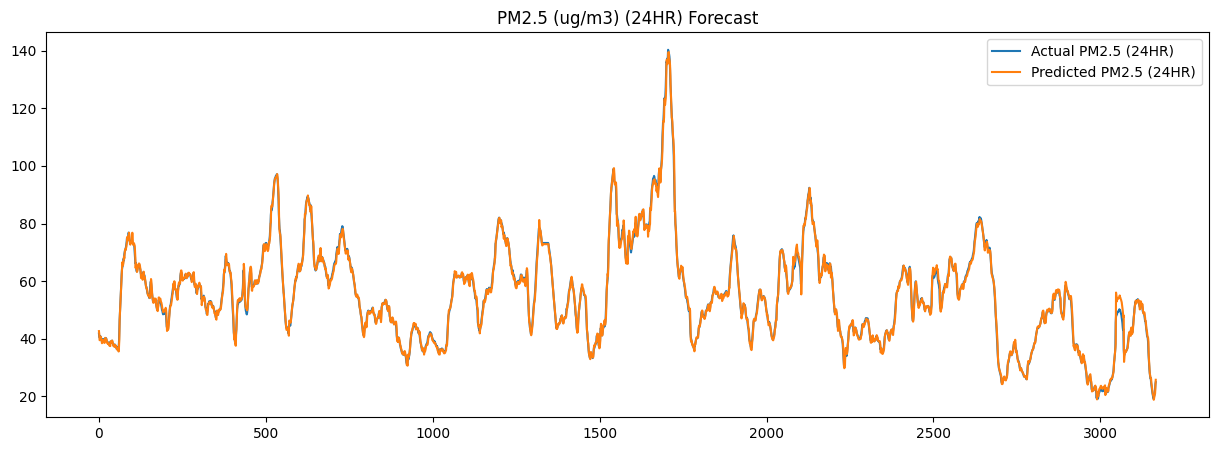

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

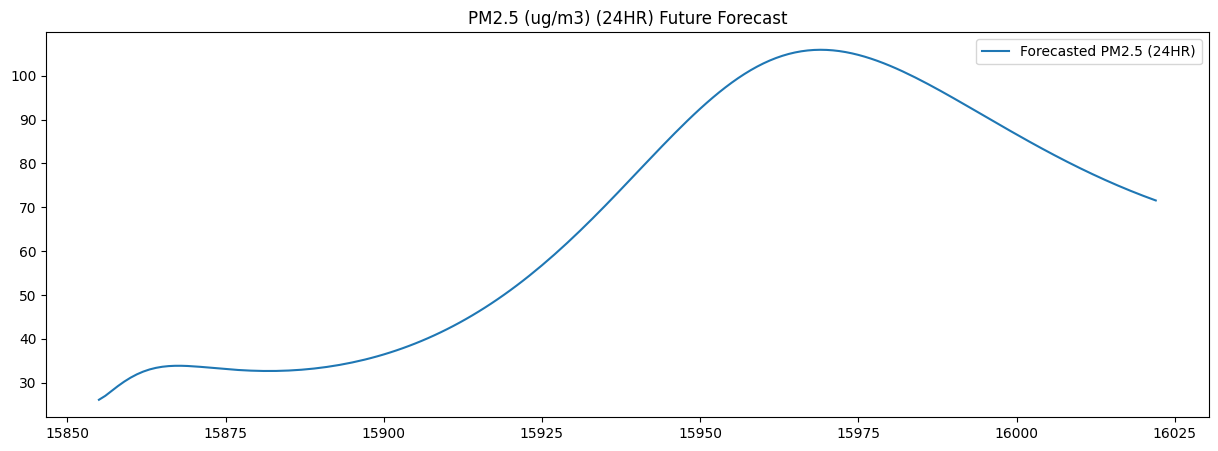

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
file_path = './AQI_Weather_Data.csv'
df = pd.read_csv(file_path)

df.set_index('Date_Start Time', inplace=True)
df.drop(['Sr.NO', 'End Time'], axis=1, inplace=True)

# Ensure PM2.5 columns are float
df['PM2.5 (ug/m3) (24HR)'] = df['PM2.5 (ug/m3) (24HR)'].astype(float)
df['PM2.5 (ug/m3) (MIN)'] = df['PM2.5 (ug/m3) (MIN)'].astype(float)
df['PM2.5 (ug/m3) (MAX)'] = df['PM2.5 (ug/m3) (MAX)'].astype(float)

# Select the features for forecasting
features = ['PM2.5 (ug/m3) (24HR)', 'PM2.5 (ug/m3) (MIN)', 'PM2.5 (ug/m3) (MAX)']

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 24
X, y = create_sequences(scaled_data, seq_length)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(seq_length, len(features))))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(len(features)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Predictions
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Evaluation
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f'Mean Squared Error: {mse}')

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(y_test_inv[:, 0], label='Actual PM2.5 (24HR)')
plt.plot(y_pred_inv[:, 0], label='Predicted PM2.5 (24HR)')
plt.legend()
plt.title('PM2.5 (ug/m3) (24HR) Forecast')
plt.show()

# Forecasting future values for the next 7 days
def forecast_future(model, data, seq_length, future_steps):
    future_predictions = []
    current_seq = data[-seq_length:]
    
    for _ in range(future_steps):
        pred = model.predict(current_seq[np.newaxis, :, :])
        future_predictions.append(pred)
        current_seq = np.append(current_seq[1:], pred, axis=0)
    
    return np.array(future_predictions)

# Forecast next 7 days (7 * 24 = 168 hours)
future_steps = 168
future_predictions = forecast_future(model, scaled_data, seq_length, future_steps)

# Inverse transform future predictions
future_predictions_inv = scaler.inverse_transform(future_predictions[:, 0, :])

# Plot future predictions
plt.figure(figsize=(15, 5))
plt.plot(range(len(df), len(df) + future_steps), future_predictions_inv[:, 0], label='Forecasted PM2.5 (24HR)')
plt.legend()
plt.title('PM2.5 (ug/m3) (24HR) Future Forecast')
plt.show()


In [4]:
def forecast_future(model, data, seq_length, future_steps):
    future_predictions = []
    current_seq = data[-seq_length:]
    
    for _ in range(future_steps):
        pred = model.predict(current_seq[np.newaxis, :, :])
        future_predictions.append(pred[0])
        current_seq = np.append(current_seq[1:], pred, axis=0)
    
    return np.array(future_predictions)

# Forecast next 7 days (7 * 24 = 168 hours)
future_steps = 24
future_predictions = forecast_future(model, scaled_data, seq_length, future_steps)

# Inverse transform future predictions
future_predictions_inv = scaler.inverse_transform(future_predictions)

# Convert future predictions to DataFrame
future_df = pd.DataFrame(future_predictions_inv, columns=features)
future_df.index = pd.date_range(start=df.index[-1], periods=future_steps, freq='H')

# Print future predictions
print(future_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
                     PM2.5 (ug/m3) (24HR)  PM2.5 (ug/m3) (MIN)  \
2023-03-31 23:00:00   

C:\Users\Anand\AppData\Local\Temp\ipykernel_15436\2409696841.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_df.index = pd.date_range(start=df.index[-1], periods=future_steps, freq='H')


# MAKING 5 MODELS FOR EACH POLLUTANT AQI


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# Load the dataset
file_path = './AQI_Weather_Data.csv'
df = pd.read_csv(file_path)

df.set_index('Date_Start Time', inplace=True)
df.drop(['Sr.NO', 'End Time'], axis=1, inplace=True)

# Ensure AQI columns are float
aqi_columns = ['AQI_PM2.5', 'AQI_PM10', 'AQI_NO2', 'AQI_CO', 'AQI_SO2']
for col in aqi_columns:
    df[col] = df[col].astype(float)

# Normalize the data for each AQI column
scalers = {}
scaled_data = {}
for col in aqi_columns:
    scaler = MinMaxScaler()
    scaled_data[col] = scaler.fit_transform(df[[col]])
    scalers[col] = scaler

# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 24

# Create sequences for each AQI column
sequences = {}
for col in aqi_columns:
    X, y = create_sequences(scaled_data[col], seq_length)
    sequences[col] = (X, y)


In [6]:
def build_and_train_model(X_train, y_train, col):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

    # Save the model
    model.save(f'{col}_LSTM_model.h5')

# Train and save models for each AQI column
for col in aqi_columns:
    X, y = sequences[col]
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    build_and_train_model(X_train, y_train, col)


c:\Users\Anand\Desktop\projects\Davies_WeatherHack\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 24, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0067 - val_loss: 2.0755e-04
Epoch 2/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 9.6783e-04 - val_loss: 7.1843e-05
Epoch 3/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 7.3412e-04 - val_loss: 8.0199e-05
Epoch 4/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 5.8623e-04 - val_loss: 5.6956e-05
Epoch 5/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 4.7393e-04 - val_loss: 3.3356e-05
Epoch 6/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 4.3064e-04 - val_loss: 3.2734e-05
Epoch 7/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 3.8212e-04 - val_loss: 2.8500e-05
Epoch 8/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 3.1083e-04 - val_loss: 2.7596e-05
Epoch 9/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 2.9846e-04 - val_loss: 1.1789e-04
Epoch 10/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 3.2100e-04 - val_loss: 4.3647e-05
Epoch 11/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 6

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 24, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0043 - val_loss: 1.7581e-04
Epoch 2/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 7.7353e-04 - val_loss: 1.0693e-04
Epoch 3/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 4.8429e-04 - val_loss: 1.0137e-04
Epoch 4/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 4.3540e-04 - val_loss: 1.3866e-04
Epoch 5/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 3.6065e-04 - val_loss: 9.7308e-05
Epoch 6/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 3.1481e-04 - val_loss: 5.6987e-05
Epoch 7/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 2.6102e-04 - val_loss: 6.4651e-05
Epoch 8/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 2.0189e-04 - val_loss: 4.0976e-05
Epoch 9/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 2.0895e-04 - val_loss: 3.1096e-05
Epoch 10/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 1.8306e-04 - val_loss: 3.4499e-05
Epoch 11/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 24, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0082 - val_loss: 3.9033e-04
Epoch 2/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0013 - val_loss: 3.0636e-04
Epoch 3/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0011 - val_loss: 2.3892e-04
Epoch 4/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 8.3583e-04 - val_loss: 9.4748e-05
Epoch 5/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 7.6421e-04 - val_loss: 9.0199e-05
Epoch 6/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 6.3746e-04 - val_loss: 8.9454e-05
Epoch 7/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 5.5090e-04 - val_loss: 1.1005e-04
Epoch 8/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 4.6083e-04 - val_loss: 5.9274e-05
Epoch 9/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 4.0222e-04 - val_loss: 4.6554e-05
Epoch 10/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 3.8542e-04 - val_loss: 4.8005e-05
Epoch 11/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 24, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0143 - val_loss: 0.0024
Epoch 2/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 3/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0017 - val_loss: 6.4361e-04
Epoch 4/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0012 - val_loss: 4.9409e-04
Epoch 5/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 8.9078e-04 - val_loss: 3.2459e-04
Epoch 6/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 7.8097e-04 - val_loss: 2.6870e-04
Epoch 7/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 7.3222e-04 - val_loss: 2.8436e-04
Epoch 8/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 6.1783e-04 - val_loss: 2.1654e-04
Epoch 9/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 5.6678e-04 - val_loss: 2.1147e-04
Epoch 10/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 5.3623e-04 - val_loss: 2.1100e-04
Epoch 11/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss:

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 24, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0044 - val_loss: 4.4765e-04
Epoch 2/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 5.7498e-04 - val_loss: 1.2382e-04
Epoch 3/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 5.4976e-04 - val_loss: 1.9542e-04
Epoch 4/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 4.7193e-04 - val_loss: 6.7873e-05
Epoch 5/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 3.3643e-04 - val_loss: 6.8104e-05
Epoch 6/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 3.6871e-04 - val_loss: 1.6807e-04
Epoch 7/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 3.2880e-04 - val_loss: 6.6466e-05
Epoch 8/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 2.2952e-04 - val_loss: 3.0821e-05
Epoch 9/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 2.0565e-04 - val_loss: 2.4251e-05
Epoch 10/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 2.2330e-04 - val_loss: 2.6225e-05
Epoch 11/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 

In [8]:
def forecast_future(model, data, seq_length, future_steps):
    future_predictions = []
    current_seq = data[-seq_length:]
    
    for _ in range(future_steps):
        pred = model.predict(current_seq[np.newaxis, :, :])
        future_predictions.append(pred[0])
        current_seq = np.append(current_seq[1:], pred, axis=0)
    
    return np.array(future_predictions)

# Forecast next 8 hours for each AQI column
future_steps = 8
future_predictions = {}

for col in aqi_columns:
    model = load_model(f'{col}_LSTM_model.h5')
    future_scaled_predictions = forecast_future(model, scaled_data[col], seq_length, future_steps)
    future_predictions[col] = scalers[col].inverse_transform(future_scaled_predictions).flatten()

# Convert future predictions to DataFrame
future_df = pd.DataFrame(future_predictions, index=pd.date_range(start=df.index[-1], periods=future_steps+1, freq='h')[1:])
print(future_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
                     AQI_PM2.5    AQI_PM10    AQI_NO2     AQI_CO    AQI_SO2
2023-04-01 00:00:00  42.472973  102.229370  49.327312  31.932623  28.024145
2023-04-01 01:00:00  43.372391  102.931725  49.198601  33.566486  28.203175
2023-04-01 02:00:00  44.211102  103.279778  49.051525  34.603954  28.438957
2023-04-01 03:00:00  44.921978  103.427887  48.899712  35.322998  28.714672
2023-04-01 04:00:00  45.542233  103.380775  48.747456  36.013943  29.024401
2023-04-01 05:00:00  46.092693  103.171753  48.596684  36.850449  29.361320
2023-04-01 06:00:00  46.587696  102.838280  48.447876  37.833912  29.719284
2023-04-01 07:00:00  47.038795  102.413216  48.300694  38.829639  30.093283


C:\Users\Anand\AppData\Local\Temp\ipykernel_15436\3433029986.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_df = pd.DataFrame(future_predictions, index=pd.date_range(start=df.index[-1], periods=future_steps+1, freq='H')[1:])


In [13]:
future_predictions

{'AQI_PM2.5': array([42.472973, 43.37239 , 44.2111  , 44.921978, 45.542233, 46.092693,
        46.587696, 47.038795], dtype=float32),
 'AQI_PM10': array([102.22937 , 102.931725, 103.27978 , 103.42789 , 103.380775,
        103.17175 , 102.83828 , 102.413216], dtype=float32),
 'AQI_NO2': array([49.327312, 49.1986  , 49.051525, 48.89971 , 48.747456, 48.596684,
        48.447876, 48.300694], dtype=float32),
 'AQI_CO': array([31.932623, 33.566486, 34.603954, 35.322998, 36.013943, 36.85045 ,
        37.83391 , 38.82964 ], dtype=float32),
 'AQI_SO2': array([28.024145, 28.203175, 28.438957, 28.714672, 29.0244  , 29.36132 ,
        29.719284, 30.093283], dtype=float32)}

In [14]:
future_df['Max_AQI'] = future_df.max(axis=1)
future_df['Max_AQI_Pollutant'] = future_df.idxmax(axis=1)

# Display the DataFrame with the maximum AQI values and corresponding pollutants
print(future_df[['Max_AQI', 'Max_AQI_Pollutant']])

                        Max_AQI Max_AQI_Pollutant
2023-04-01 00:00:00  102.229370          AQI_PM10
2023-04-01 01:00:00  102.931725          AQI_PM10
2023-04-01 02:00:00  103.279778          AQI_PM10
2023-04-01 03:00:00  103.427887          AQI_PM10
2023-04-01 04:00:00  103.380775          AQI_PM10
2023-04-01 05:00:00  103.171753          AQI_PM10
2023-04-01 06:00:00  102.838280          AQI_PM10
2023-04-01 07:00:00  102.413216          AQI_PM10
